In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import cm
from palettable.colorbrewer.diverging import RdBu_4

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
# import flow cytometry data directly from myria
fileURL1 = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-particle_stats_byfile/data?format=csv'
result = pd.read_csv(fileURL1)

# load in the SDS data so that we can look at clusters in T/S space and "real" space
# also want to get seasons/months of year for each file
fileURL2 = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL2)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)

# join sds dataframe to cluster results
new_table = pd.merge(sds, result, how="inner")

# select the subset of variables to cluster over
#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['fsc_avg','chl_avg','pe_avg']].values  


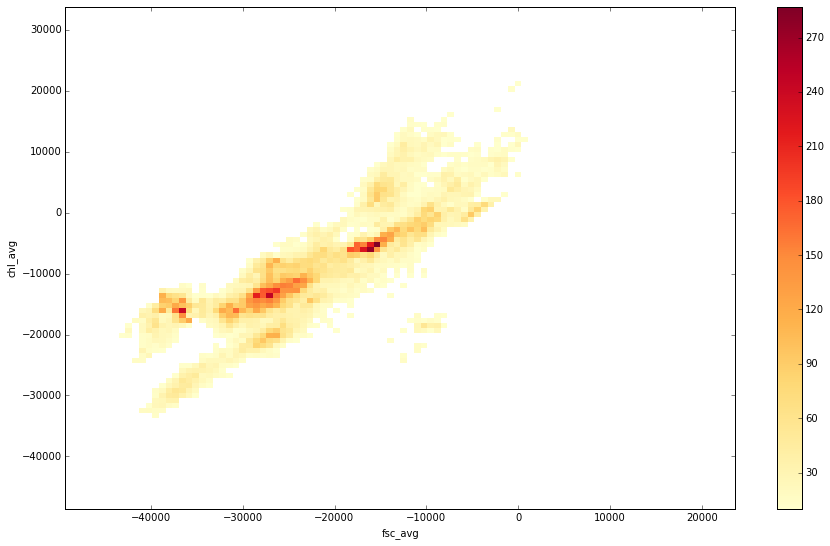

In [3]:
# plot the data to see if it seems to fall into particular clusters right off the bat

from palettable.colorbrewer.sequential import YlOrRd_9

fig1 = plt.figure(1, figsize=(15,9))
plt.hist2d(result['fsc_avg'],result['chl_avg'],bins=100, cmap=YlOrRd_9.mpl_colormap, cmin=10, cmax=290)
plt.xlabel('fsc_avg')
plt.ylabel('chl_avg')
plt.colorbar()
plt.show()

In [4]:
# try hierarchical clustering on the data
# do not have to specify number of clusters

from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist, pdist

# Start by estimating optimal number of clusters
# uses method from this stack overflow post: 
# http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means
K = range(1,40)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
#avgWithinSS = [sum(d)/X.shape[0] for d in dist]
tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares


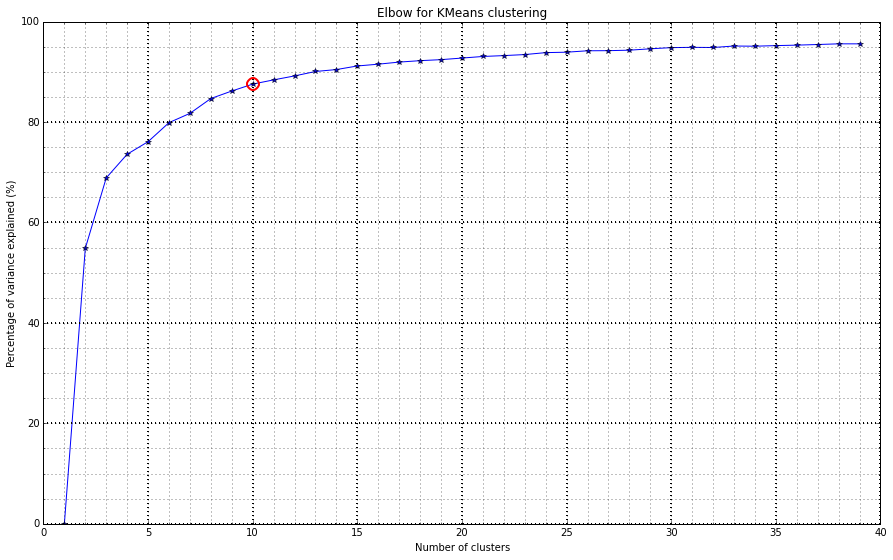

In [5]:
# The elbow curve gives an idea of the number of clusters needed to explain the variance in the data.

##### plot ###
kIdx = 9

# elbow curve
fig2 = plt.figure(2, figsize=(15,9))
ax = fig2.add_subplot(111)
ax.plot(K, betweenss/totss*100, 'b*-')
ax.plot(K[kIdx], betweenss[kIdx]/totss*100, marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.xaxis.grid(True,'minor')
ax.yaxis.grid(True,'minor')
ax.xaxis.grid(True,'major',linewidth=2)
ax.yaxis.grid(True,'major',linewidth=2)
plt.show()

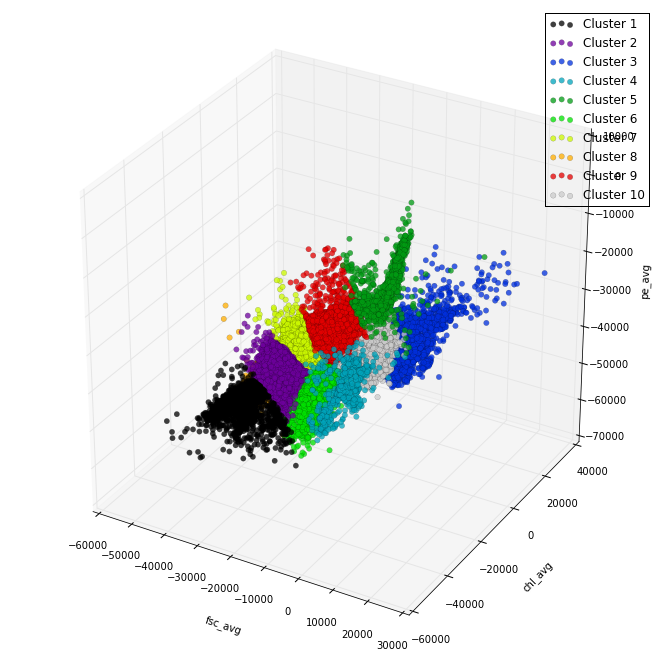

In [12]:
# scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig3 = plt.figure(5, figsize=(9,9))
ax = Axes3D(fig3)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = plt.cm.spectral( np.linspace(0,1,kIdx+1) ).tolist()
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X[ind,0],X[ind,1],X[ind,2], s=30, c=clr[i], alpha = 0.75, label='Cluster %d'%(i+1), edgecolor='black', linewidth=0.15)
plt.grid(True)
ax.set_xlabel('fsc_avg')
ax.set_ylabel('chl_avg')  
ax.set_zlabel('pe_avg')
plt.legend()
plt.show()